In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Station = Base.classes.station
Measurement = Base.classes.measurement

C:\Users\leahm\AppData\Local\Temp\ipykernel_22268\478002734.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f'Most recent date: {recent_date}')

Most recent date: 2017-08-23


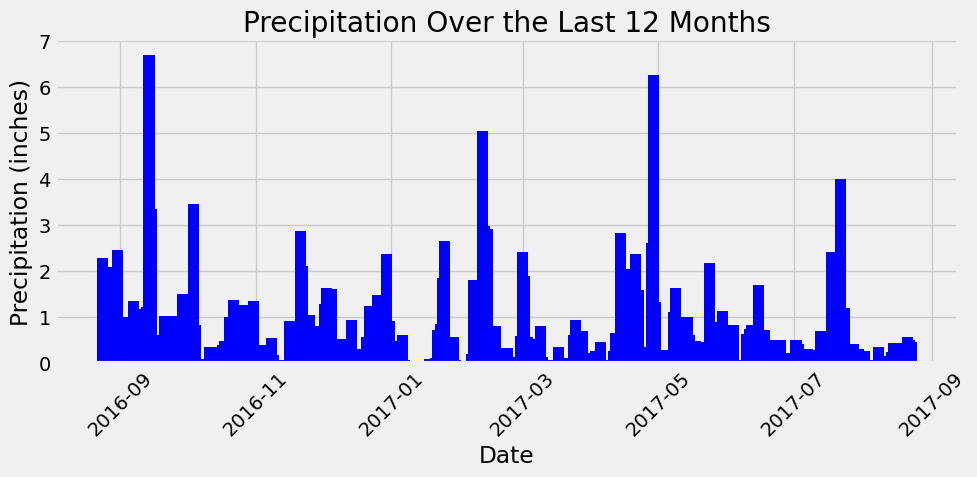

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
recent_date = dt.datetime.strptime(recent_date, "%Y-%m-%d")
one_year_ago = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_precipitation = pd.DataFrame(precipitation_data, columns=["date", "prcp"])


# Sort the dataframe by date
df_precipitation["date"] = pd.to_datetime(df_precipitation["date"])
df_precipitation.sort_values("date", inplace=True)



# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(10, 5))
plt.bar(df_precipitation["date"], df_precipitation["prcp"], width=5, color='blue')
plt.title("Precipitation Over the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
print(df_precipitation.describe())


                                date         prcp
count                           2223  2015.000000
mean   2017-02-16 18:54:53.927125248     0.176462
min              2016-08-24 00:00:00     0.000000
25%              2016-11-19 00:00:00     0.000000
50%              2017-02-15 00:00:00     0.020000
75%              2017-05-17 00:00:00     0.130000
max              2017-08-23 00:00:00     6.700000
std                              NaN     0.460288


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).count()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    Measurement.station,
    func.count(Measurement.station).label("observation_count")
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for station, count in most_active_stations:
    print(f"Station ID: {station}, Observations: {count}")

Station ID: USC00519281, Observations: 2772
Station ID: USC00519397, Observations: 2724
Station ID: USC00513117, Observations: 2709
Station ID: USC00519523, Observations: 2669
Station ID: USC00516128, Observations: 2612
Station ID: USC00514830, Observations: 2202
Station ID: USC00511918, Observations: 1979
Station ID: USC00517948, Observations: 1372
Station ID: USC00518838, Observations: 511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'
temperature_stats = session.query(
    func.min(Measurement.tobs).label("min_temp"),
    func.max(Measurement.tobs).label("max_temp"),
    func.avg(Measurement.tobs).label("avg_temp")
).filter(Measurement.station == most_active_station_id).all()
for stat in temperature_stats:
    print(f"Station ID: {most_active_station_id}")
    print(f"Min Temp: {stat.min_temp}, Max Temp: {stat.max_temp}, Avg Temp: {stat.avg_temp}")


Station ID: USC00519281
Min Temp: 54.0, Max Temp: 85.0, Avg Temp: 71.66378066378067


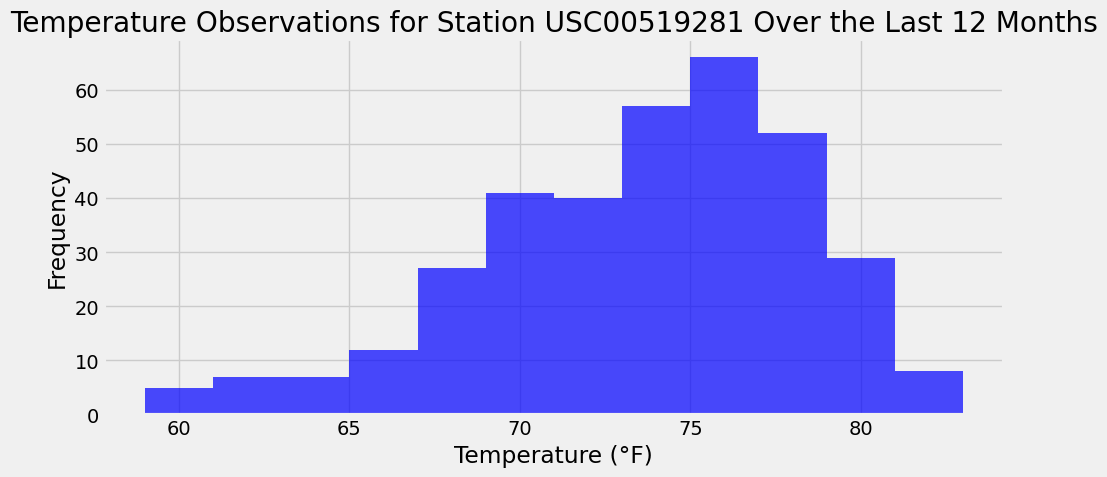

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_ago = recent_date - dt.timedelta(days=365)
tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).\
    all()
df_tobs = pd.DataFrame(tobs_data, columns=["tobs"])

plt.figure(figsize=(10, 5))
plt.hist(df_tobs["tobs"], bins=12, color='blue', alpha=0.7)
plt.title(f"Temperature Observations for Station {most_active_station_id} Over the Last 12 Months")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [17]:
# Close Session
session.close()